In [2]:
%matplotlib auto
import os
import mne
import mne_nirs
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pandas as pd
import numpy as np
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from nilearn.plotting import plot_design_matrix
from mne_connectivity import envelope_correlation
from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair)


Using matplotlib backend: QtAgg


In [3]:
gyoto, sherabling, kathmandu = [], [], []
files_all = []
cd = os.getcwd()
for path, subdirs, files in os.walk(cd):
    for name in files:
        filename = os.path.join(path, name)
        files_all.append(filename)
        
gyoto = [i for i in files_all if "gyoto" in i if  ".snirf" in i]
kathmandu = [i for i in files_all if "kathmandu" in i if ".snirf" in i]
sherabling = [i for i in files_all if "sherabling" in i if ".snirf" in i]


In [10]:
# path[36:-6]

path = sherabling[0]

raw_snirf = mne.io.read_raw_snirf(path)
raw_snirf = raw_snirf.crop(tmin=10., tmax=raw_snirf.times[-1]-10)

bad_channels = ['S13_D6 hbo', 'S11_D9 hbo']

raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

lowpass, highpass = 0.01, 0.1
raw_haemo = raw_haemo.filter(l_freq=lowpass, h_freq=highpass)
raw_haemo = raw_haemo.resample(sfreq=2.)

# bad_channels = ['S13_D6 hbo', 'S11_D9 hbo']
# lowpass, highpass = 0.01, 0.05
# raw_haemo = raw_haemo.filter(l_freq=lowpass, h_freq=highpass)
# raw_haemo = raw_haemo.resample(sfreq=1.)


# raw_snirf.plot()

Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Reading 0 ... 17301  =      0.000 ...  1700.688 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 3359 samples (330.190 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


In [12]:
raw_haemo.to

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D3 hbo, S2_D1 hbo, S2_D2 hbo, S2_D4 hbo, S2_D16 ...
 chs: 54 Oxyhemoglobin, 54 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 300 items (2 Cardinal, 298 EEG)
 highpass: 0.0 Hz
 lowpass: 0.1 Hz
 meas_date: 2022-05-05 08:21:31 UTC
 nchan: 108
 projs: []
 sfreq: 2.0 Hz
 subject_info: 1 item (dict)
>

In [111]:
epochs_duration = 3
epochs = mne.make_fixed_length_epochs(raw_haemo, duration=epochs_duration)
epoch  = epochs.get_data()
meaned_epochs = epoch.mean(axis=2)    

meaned_epochs

Not setting metadata
566 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 566 events and 31 original time points ...
0 bad epochs dropped


array([[-2.55257581e-07, -9.47292009e-08, -1.53457977e-07, ...,
        -6.91507849e-09,  3.86228484e-07,  1.07238442e-06],
       [-4.75912169e-07, -3.74374587e-07, -3.00377005e-07, ...,
         9.25514129e-09,  4.75433676e-07,  1.92313174e-06],
       [-4.30567191e-07, -7.80018133e-07, -3.30282084e-08, ...,
         2.04463494e-07,  5.30792969e-07,  3.89300780e-07],
       ...,
       [ 1.77079038e-07,  2.73052161e-07,  2.24060786e-07, ...,
        -6.59601742e-08,  3.89697012e-08,  2.97397714e-08],
       [-2.21177834e-08,  5.97595179e-08,  3.44604616e-08, ...,
        -1.44341613e-07, -4.60278551e-08, -3.76185617e-08],
       [ 3.52277684e-07,  3.47488696e-07,  5.16714844e-08, ...,
         2.30313766e-08, -4.60662210e-08, -1.42325380e-07]])

In [116]:
from sklearn.preprocessing import StandardScaler


scaler=StandardScaler()
scaler.fit(meaned_epochs)
scaled_data=scaler.transform(meaned_epochs)
scaled_data


array([[-5.90491392e-01, -2.57601252e-01, -6.32473306e-01, ...,
         1.16498707e-03,  2.59721349e+00,  7.42190028e-01],
       [-1.14965525e+00, -1.12576222e+00, -1.26396410e+00, ...,
         8.22671752e-02,  3.18966564e+00,  1.40495896e+00],
       [-1.03474591e+00, -2.38508531e+00, -1.14839265e-01, ...,
         1.06134011e+00,  3.55733182e+00,  2.10038340e-01],
       ...,
       [ 5.05098841e-01,  8.84178434e-01,  9.90186653e-01, ...,
        -2.94977337e-01,  2.90910350e-01, -7.00752295e-02],
       [ 3.11408913e-04,  2.22010003e-01,  1.75242113e-01, ...,
        -6.88101630e-01, -2.73596987e-01, -1.22550283e-01],
       [ 9.49072165e-01,  1.11526715e+00,  2.49218933e-01, ...,
         1.51362267e-01, -2.73851792e-01, -2.04121421e-01]])

In [32]:
print(raw_snirf.time_as_index)

<bound method BaseRaw.time_as_index of <RawSNIRF | 2022-05-05_003.snirf, 108 x 17293 (1699.8 s), ~227 kB, data not loaded>>


In [7]:
matplotlib.use('Agg')

for path in sherabling:
    
    folder_name = path[36:-6] + "//"
    raw_snirf = mne.io.read_raw_snirf(path)
    raw_snirf.load_data()
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    corrected_tddr_hilbert = corrected_tddr.apply_hilbert(envelope=True)

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr_hilbert)
    raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
                                 l_trans_bandwidth=0.02)
    
    hbo_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbo" in i])
    hbr_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbr" in i])
    
    epochs_duration = 10
    epochs = mne.make_fixed_length_epochs(hbo_channels_picked, duration=epochs_duration)
    epoch  = epochs.get_data()

    mean_epochs = epoch.mean(axis=2)
    vmin = mean_epochs.min()
    vmax = mean_epochs.max()

    dirnames = ("/home/avaldamon/Desktop/fnirs_topos_10_secs//" + folder_name)
    os.makedirs(dirnames, exist_ok=True)
    np.save(file=dirnames+"mean_channels_10_sec_epochs", arr=mean_epochs)
    
    for i in range (0, mean_epochs.shape[0]):

        ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=hbo_channels_picked.info, size=8, vlim=(vmin, vmax), show=False)
        ax_figure = ax.get_figure()
        title = f'HbO topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
        ax_figure.suptitle(title)
        clb = plt.colorbar(ax)
        picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s"
        plt.savefig(dirnames + picname + ".png", )
        plt.close()

        
for path in gyoto:
    
    folder_name = path[36:-6] + "//"
    raw_snirf = mne.io.read_raw_snirf(path)
    raw_snirf.load_data()
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    corrected_tddr_hilbert = corrected_tddr.apply_hilbert(envelope=True)

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr_hilbert)
    raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
                                 l_trans_bandwidth=0.02)
    
    hbo_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbo" in i])
    hbr_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbr" in i])
    
    epochs_duration = 10
    epochs = mne.make_fixed_length_epochs(hbo_channels_picked, duration=epochs_duration)
    epoch  = epochs.get_data()

    mean_epochs = epoch.mean(axis=2)
    vmin = mean_epochs.min()
    vmax = mean_epochs.max()
    
    
    dirnames = ("/home/avaldamon/Desktop/fnirs_topos_10_secs//" + folder_name)
    os.makedirs(dirnames, exist_ok=True)
    np.save(file=dirnames+"mean_channels_10_sec_epochs", arr=mean_epochs)

    for i in range (0, mean_epochs.shape[0]):

        ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=hbo_channels_picked.info, size=8, vlim=(vmin, vmax), show=False)
        ax_figure = ax.get_figure()
        title = f'HbO topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
        ax_figure.suptitle(title)
        clb = plt.colorbar(ax)
        picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s"
        plt.savefig(dirnames + picname + ".png", )
        plt.close()
        

for path in kathmandu:
    
    folder_name = path[36:-6] + "//"
    raw_snirf = mne.io.read_raw_snirf(path)
    raw_snirf.load_data()
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    corrected_tddr_hilbert = corrected_tddr.apply_hilbert(envelope=True)

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr_hilbert)
    raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
                                 l_trans_bandwidth=0.02)
    
    hbo_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbo" in i])
    hbr_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbr" in i])
    
    epochs_duration = 10
    epochs = mne.make_fixed_length_epochs(hbo_channels_picked, duration=epochs_duration)
    epoch  = epochs.get_data()

    mean_epochs = epoch.mean(axis=2)
    vmin = mean_epochs.min()
    vmax = mean_epochs.max()

    dirnames = ("/home/avaldamon/Desktop/fnirs_topos_10_secs//" + folder_name)
    os.makedirs(dirnames, exist_ok=True)
    np.save(file=dirnames+"mean_channels_10_sec_epochs", arr=mean_epochs)
    
    
    for i in range (0, mean_epochs.shape[0]):

        ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=hbo_channels_picked.info, size=8, vlim=(vmin, vmax), show=False)
        ax_figure = ax.get_figure()
        title = f'HbO topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
        ax_figure.suptitle(title)
        clb = plt.colorbar(ax)
        picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s"
        plt.savefig(dirnames + picname + ".png", )
        plt.close()
    
    

Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Reading 0 ... 17505  =      0.000 ...  1720.741 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 102 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_004/2022-05-05_004.snirf
Reading 0 ... 12236  =      0.000 ...  1202.799 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_005/2022-05-05_005.snirf
Reading 0 ... 1457  =      0.000 ...   143.223 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1458), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_001/2022-05-05_001.snirf
Reading 0 ... 1440  =      0.000 ...   141.552 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1441), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_002/2022-05-05_002.snirf
Reading 0 ... 1658  =      0.000 ...   162.981 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1659), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_006/2022-05-05_006.snirf
Reading 0 ... 1292  =      0.000 ...   127.004 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1293), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/tenpa rabgye/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Reading 0 ... 20964  =      0.000 ...  2060.761 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 206 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/tenpa rabgye/2022-05-05/2022-05-05_004/2022-05-05_004.snirf
Reading 0 ... 1323  =      0.000 ...   130.051 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1324), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/tenpa rabgye/2022-05-05/2022-05-05_005/2022-05-05_005.snirf
Reading 0 ... 1339  =      0.000 ...   131.624 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1340), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/tenpa rabgye/2022-05-05/2022-05-05_001/2022-05-05_001.snirf
Reading 0 ... 2012  =      0.000 ...   197.780 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/tenpa rabgye/2022-05-05/2022-05-05_002/2022-05-05_002.snirf
Reading 0 ... 1517  =      0.000 ...   149.121 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1518), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/Tsering Tashi/2022-05-06/2022-05-06_002/2022-05-06_002.snirf
Reading 0 ... 1581  =      0.000 ...   155.412 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1582), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/Tsering Tashi/2022-05-06/2022-05-06_001/2022-05-06_001.snirf
Reading 0 ... 1394  =      0.000 ...   137.030 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1395), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/Tsering Tashi/2022-05-06/2022-05-06_005/2022-05-06_005.snirf
Reading 0 ... 1365  =      0.000 ...   134.179 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1366), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/Tsering Tashi/2022-05-06/2022-05-06_003/2022-05-06_003.snirf
Reading 0 ... 5775  =      0.000 ...   567.683 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 56 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/Tsering Tashi/2022-05-06/2022-05-06_004/2022-05-06_004.snirf
Reading 0 ... 1405  =      0.000 ...   138.111 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1406), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/dhomay/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Reading 0 ... 20673  =      0.000 ...  2032.156 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 203 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/dhomay/2022-05-05/2022-05-05_004/2022-05-05_004.snirf
Reading 0 ... 1747  =      0.000 ...   171.730 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/dhomay/2022-05-05/2022-05-05_005/2022-05-05_005.snirf
Reading 0 ... 1427  =      0.000 ...   140.274 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1428), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/dhomay/2022-05-05/2022-05-05_001/2022-05-05_001.snirf
Reading 0 ... 1874  =      0.000 ...   184.214 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/dhomay/2022-05-05/2022-05-05_002/2022-05-05_002.snirf
Reading 0 ... 1369  =      0.000 ...   134.573 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1370), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/mintup phuntsok/2022-05-04/2022-05-04_002/2022-05-04_002.snirf
Reading 0 ... 1845  =      0.000 ...   181.363 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/mintup phuntsok/2022-05-04/2022-05-04_004/2022-05-04_004.snirf
Reading 0 ... 1339  =      0.000 ...   131.624 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1340), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/mintup phuntsok/2022-05-04/2022-05-04_003/2022-05-04_003.snirf
Reading 0 ... 21651  =      0.000 ...  2128.293 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 212 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/mintup phuntsok/2022-05-04/2022-05-04_001/2022-05-04_001.snirf
Reading 0 ... 2883  =      0.000 ...   283.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 28 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/mintup phuntsok/2022-05-04/2022-05-04_005/2022-05-04_005.snirf
Reading 0 ... 1390  =      0.000 ...   136.637 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1391), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/thupten jigdrel/2022-05-06/2022-05-06_002/2022-05-06_002.snirf
Reading 0 ... 1366  =      0.000 ...   134.278 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1367), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/thupten jigdrel/2022-05-06/2022-05-06_001/2022-05-06_001.snirf
Reading 0 ... 1564  =      0.000 ...   153.741 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1565), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/thupten jigdrel/2022-05-06/2022-05-06_005/2022-05-06_005.snirf
Reading 0 ... 1381  =      0.000 ...   135.752 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1382), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/thupten jigdrel/2022-05-06/2022-05-06_004/2022-05-06_004.snirf
Reading 0 ... 1282  =      0.000 ...   126.021 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1283), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/tsewang nima/2022-05-03/2022-05-03_002/2022-05-03_002.snirf
Reading 0 ... 2042  =      0.000 ...   200.729 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/tsewang nima/2022-05-03/2022-05-03_005/2022-05-03_005.snirf
Reading 0 ... 1675  =      0.000 ...   164.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1676), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/tsewang nima/2022-05-03/2022-05-03_001/2022-05-03_001.snirf
Reading 0 ... 1975  =      0.000 ...   194.142 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/tsewang nima/2022-05-03/2022-05-03_003/2022-05-03_003.snirf
Reading 0 ... 27186  =      0.000 ...  2672.384 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
267 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 267 events and 102 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/tsewang nima/2022-05-03/2022-05-03_004/2022-05-03_004.snirf
Reading 0 ... 1880  =      0.000 ...   184.804 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/phurpa wangchuck/2022-05-02/2022-05-02_002/2022-05-02_002.snirf
Reading 0 ... 1424  =      0.000 ...   139.979 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1425), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/phurpa wangchuck/2022-05-02/2022-05-02_001/2022-05-02_001.snirf
Reading 0 ... 2088  =      0.000 ...   205.250 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/phurpa wangchuck/2022-05-02/2022-05-02_005/2022-05-02_005.snirf
Reading 0 ... 1582  =      0.000 ...   155.511 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1583), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/phurpa wangchuck/2022-05-02/2022-05-02_004/2022-05-02_004.snirf
Reading 0 ... 1005  =      0.000 ...    98.791 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 9 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1006), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/phurpa wangchuck/2022-05-02/2022-05-02_003/2022-05-02_003.snirf
Reading 0 ... 20156  =      0.000 ...  1981.335 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
198 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 198 events and 102 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/karma zopa/2022-05-04/2022-05-04_002/2022-05-04_002.snirf
Reading 0 ... 1548  =      0.000 ...   152.168 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1549), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/karma zopa/2022-05-04/2022-05-04_004/2022-05-04_004.snirf
Reading 0 ... 1308  =      0.000 ...   128.576 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1309), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/karma zopa/2022-05-04/2022-05-04_003/2022-05-04_003.snirf
Reading 0 ... 19533  =      0.000 ...  1920.094 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/karma zopa/2022-05-04/2022-05-04_001/2022-05-04_001.snirf
Reading 0 ... 2674  =      0.000 ...   262.854 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 26 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/samatha/karma zopa/2022-05-04/2022-05-04_005/2022-05-04_005.snirf
Reading 0 ... 1499  =      0.000 ...   147.352 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1500), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/tulku tenpa rabgye/2022-04-30/2022-04-30_002/2022-04-30_002.snirf
Reading 0 ... 1210  =      0.000 ...   118.943 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1211), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/tulku tenpa rabgye/2022-04-30/2022-04-30_003/2022-04-30_003.snirf
Reading 0 ... 12462  =      0.000 ...  1225.015 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.4s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/tulku tenpa rabgye/2022-04-30/2022-04-30_001/2022-04-30_001.snirf
Reading 0 ... 4500  =      0.000 ...   442.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 44 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/tulku tenpa rabgye/2022-04-30/2022-04-30_004/2022-04-30_004.snirf
Reading 0 ... 1315  =      0.000 ...   129.264 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1316), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/tulku tenpa rabgye/2022-04-30/2022-04-30_005/2022-04-30_005.snirf
Reading 0 ... 1411  =      0.000 ...   138.701 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1412), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_006/2022-05-01_006.snirf
Reading 0 ... 1853  =      0.000 ...   182.150 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_002/2022-05-01_002.snirf
Reading 0 ... 1508  =      0.000 ...   148.236 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1509), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_003/2022-05-01_003.snirf
Reading 0 ... 18905  =      0.000 ...  1858.361 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
185 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 185 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_004/2022-05-01_004.snirf
Reading 0 ... 1433  =      0.000 ...   140.864 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1434), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_005/2022-05-01_005.snirf
Reading 0 ... 1331  =      0.000 ...   130.837 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1332), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/thupten karma/2022-05-01/2022-05-01_001/2022-05-01_001.snirf
Reading 0 ... 1755  =      0.000 ...   172.516 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_007/2022-05-01_007.snirf
Reading 0 ... 4803  =      0.000 ...   472.135 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 47 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_006/2022-05-01_006.snirf
Reading 0 ... 1612  =      0.000 ...   158.460 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1613), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_002/2022-05-01_002.snirf
Reading 0 ... 1455  =      0.000 ...   143.026 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1456), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_003/2022-05-01_003.snirf
Reading 0 ... 16434  =      0.000 ...  1615.462 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 161 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_004/2022-05-01_004.snirf
Reading 0 ... 7051  =      0.000 ...   693.113 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_005/2022-05-01_005.snirf
Reading 0 ... 1470  =      0.000 ...   144.501 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1471), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma choezin/2022-05-01/2022-05-01_001/2022-05-01_001.snirf
Reading 0 ... 2004  =      0.000 ...   196.993 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/kama dhondup dorjee/2022-04-30/2022-04-30_002/2022-04-30_002.snirf
Reading 0 ... 1368  =      0.000 ...   134.474 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1369), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/kama dhondup dorjee/2022-04-30/2022-04-30_003/2022-04-30_003.snirf
Reading 0 ... 23150  =      0.000 ...  2275.645 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 227 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/kama dhondup dorjee/2022-04-30/2022-04-30_001/2022-04-30_001.snirf
Reading 0 ... 2239  =      0.000 ...   220.094 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/kama dhondup dorjee/2022-04-30/2022-04-30_004/2022-04-30_004.snirf
Reading 0 ... 1319  =      0.000 ...   129.658 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1320), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/kama dhondup dorjee/2022-04-30/2022-04-30_005/2022-04-30_005.snirf
Reading 0 ... 1720  =      0.000 ...   169.076 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_002/2022-05-02_002.snirf
Reading 0 ... 1786  =      0.000 ...   175.564 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_006/2022-05-02_006.snirf
Reading 0 ... 1528  =      0.000 ...   150.202 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1529), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_001/2022-05-02_001.snirf
Reading 0 ... 2456  =      0.000 ...   241.425 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_005/2022-05-02_005.snirf
Reading 0 ... 1380  =      0.000 ...   135.654 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1381), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_004/2022-05-02_004.snirf
Reading 0 ... 1410  =      0.000 ...   138.603 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:14: RuntimeWarning: filter_length (1679) is longer than the signal (1411), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tantric/karma tenzin/2022-05-02/2022-05-02_003/2022-05-02_003.snirf
Reading 0 ... 11960  =      0.000 ...  1175.668 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
117 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 117 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27_2/meditation/2022-04-27_005/2022-04-27_005.snirf
Reading 0 ... 4698  =      0.000 ...   923.627 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27_2/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 616  =      0.000 ...   121.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (617), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27_2/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 691  =      0.000 ...   135.851 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (692), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27_2/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 759  =      0.000 ...   149.219 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (760), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27_2/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 659  =      0.000 ...   129.559 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (660), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26_2/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26_2/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 670  =      0.000 ...   131.722 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (671), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26_2/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26_2/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26_2/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 904  =      0.000 ...   177.726 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 741  =      0.000 ...   145.681 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (742), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 13807  =      0.000 ...  2714.456 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 271 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-27/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 825  =      0.000 ...   162.195 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (826), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_2/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 2421  =      0.000 ...   237.984 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_2/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 20451  =      0.000 ...  2010.333 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_2/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1327  =      0.000 ...   130.444 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1328), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_2/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1384  =      0.000 ...   136.047 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1385), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_2/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1326  =      0.000 ...   130.346 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1327), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 891  =      0.000 ...   175.171 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 7503  =      0.000 ...  1475.090 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 624  =      0.000 ...   122.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (625), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1297  =      0.000 ...   254.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25_2/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 431  =      0.000 ...    84.735 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (432), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25_2/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 6892  =      0.000 ...  1354.967 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 135 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25_2/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 993  =      0.000 ...   195.224 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25_2/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 696  =      0.000 ...   136.834 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (697), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25_2/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_3/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 1325  =      0.000 ...   130.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1326), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_3/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 24017  =      0.000 ...  2360.871 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
236 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


0 projection items activated
Using data from preloaded Raw for 236 events and 102 original time points ...
0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_3/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1217  =      0.000 ...   119.631 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 ev

/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1218), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_3/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1236  =      0.000 ...   121.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1237), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-28_3/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1267  =      0.000 ...   124.546 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1268), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-29/2022-04-29_005/2022-04-29_005.snirf
Reading 0 ... 1252  =      0.000 ...   123.072 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1253), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-29/2022-04-29_003/2022-04-29_003.snirf
Reading 0 ... 31348  =      0.000 ...  3081.508 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


Not setting metadata
308 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 308 events and 102 original time points ...
0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-29/2022-04-29_002/2022-04-29_002.snirf
Reading 0 ... 1985  =      0.000 ...   195.125 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-29/2022-04-29_001/2022-04-29_001.snirf
Reading 0 ... 2968  =      0.000 ...   291.754 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-29/2022-04-29_004/2022-04-29_004.snirf
Reading 0 ... 1277  =      0.000 ...   125.529 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (1679) is longer than the signal (1278), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-24/2022-04-24_002/2022-04-24_002.snirf
Reading 0 ... 629  =      0.000 ...   123.661 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (630), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-24/2022-04-24_003/2022-04-24_003.snirf
Reading 0 ... 10809  =      0.000 ...  2125.049 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 212 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-24/2022-04-24_001/2022-04-24_001.snirf
Reading 0 ... 634  =      0.000 ...   124.644 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (635), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 882  =      0.000 ...   173.401 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 625  =      0.000 ...   122.875 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (626), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-26/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 623  =      0.000 ...   122.482 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (624), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 766  =      0.000 ...   150.596 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (767), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 18168  =      0.000 ...  3571.829 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
357 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 357 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 621  =      0.000 ...   122.089 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/2022-04-25/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:55: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1723  =      0.000 ...   169.371 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1562  =      0.000 ...   153.545 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1563), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 11486  =      0.000 ...  1129.074 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 1419  =      0.000 ...   139.488 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1420), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1873  =      0.000 ...   184.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2058  =      0.000 ...   202.301 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 3766  =      0.000 ...   370.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 2394  =      0.000 ...   235.330 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 2199  =      0.000 ...   216.162 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 1581  =      0.000 ...   155.412 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1582), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 2009  =      0.000 ...   197.485 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1860  =      0.000 ...   182.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1216  =      0.000 ...   119.533 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1217), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1552  =      0.000 ...   152.562 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1553), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 15695  =      0.000 ...  1542.818 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1262  =      0.000 ...   124.055 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1263), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 3854  =      0.000 ...   378.848 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1627  =      0.000 ...   159.934 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1628), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2625  =      0.000 ...   258.037 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 4257  =      0.000 ...   418.463 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_009/2022-05-08_009.snirf
Reading 0 ... 1504  =      0.000 ...   147.843 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1505), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 11042  =      0.000 ...  1085.429 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 108 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 6237  =      0.000 ...   613.097 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 3412  =      0.000 ...   335.400 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 1546  =      0.000 ...   151.972 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4598/441399098.py:97: RuntimeWarning: filter_length (1679) is longer than the signal (1547), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


In [4]:
path = sherabling[0]
print(path)
raw_snirf = mne.io.read_raw_snirf(path)
raw_snirf.load_data()

/home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Loading /home/avaldamon/Desktop/india-fnirs/sherabling/tumo/karma dudak tulku/2022-05-05/2022-05-05_003/2022-05-05_003.snirf
Reading 0 ... 17505  =      0.000 ...  1720.741 secs...


<RawSNIRF | 2022-05-05_003.snirf, 108 x 17506 (1720.7 s), ~14.6 MB, data loaded>

In [126]:
import asyncio

async def inlay_hbo():
    await hbo
    if hbo:

        ch_type = "hbo"
        mean_epochs = mean_epochs[:, :54]

        vmin = mean_epochs.min()
        vmax = mean_epochs.max()

        if normalize_epochs:
            vmin_abs = np.absolute(mean_epochs.min())
            vmax_abs = np.absolute(mean_epochs.max())
            normalizer = max(vmax_abs, vmax_abs)
            mean_epochs = mean_epochs/normalizer

            vmin = mean_epochs.min()
            vmax = mean_epochs.max()


        dirnames = (f"{directory}{epochs_duration}_secs/{ch_type}//" + folder_name)
        os.makedirs(dirnames, exist_ok=True)
        np.save(file=dirnames+f"mean_channels_{epochs_duration}_sec_epochs", arr=mean_epochs)

        for i in range (0, mean_epochs.shape[0]):

            ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=pos, 
                                            size=8, vlim=(vmin, vmax), 
                                            show=False)
            ax_figure = ax.get_figure()
            title = f'{ch_type} topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
            ax_figure.suptitle(title)
            clb = plt.colorbar(ax)
            picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s {ch_type}"
            plt.savefig(dirnames + picname + ".png", )
            plt.close()
    else:
        pass

async def inlay_hbr():
    await hbr
    if hbr:

        ch_type = "hbr"
        mean_epochs = mean_epochs[:, 54:]

        vmin = mean_epochs.min()
        vmax = mean_epochs.max()

        if normalize_epochs:
            vmin_abs = np.absolute(mean_epochs.min())
            vmax_abs = np.absolute(mean_epochs.max())
            normalizer = max(vmax_abs, vmax_abs)
            mean_epochs = mean_epochs/normalizer

            vmin = mean_epochs.min()
            vmax = mean_epochs.max()


        dirnames = (f"{directory}{epochs_duration}_secs/{ch_type}//" + folder_name)
        os.makedirs(dirnames, exist_ok=True)
        np.save(file=dirnames+f"mean_channels_{epochs_duration}_sec_epochs", arr=mean_epochs)

        for i in range (0, mean_epochs.shape[0]):

            ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=pos, 
                                            size=8, vlim=(vmin, vmax), 
                                            show=False)
            ax_figure = ax.get_figure()
            title = f'{ch_type} topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
            ax_figure.suptitle(title)
            clb = plt.colorbar(ax)
            picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s {ch_type}"
            plt.savefig(dirnames + picname + ".png", )
            plt.close()
    else:
        pass


def processing_and_plotting(path, hbo=True, hbr=True, epochs_duration=10, 
                            normalize_epochs=True, 
                            directory="/home/avaldamon/Desktop/new_fnirs_topos_"):
    folder_name = path[36:-6] + "//"
    raw_snirf = mne.io.read_raw_snirf(path)
    raw_snirf.load_data()
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    corrected_tddr_hilbert = corrected_tddr.apply_hilbert(envelope=True)

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr_hilbert)
    raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
                                 l_trans_bandwidth=0.02)
    
    epochs = mne.make_fixed_length_epochs(raw_haemo, duration=epochs_duration)
    epoch  = epochs.get_data()
    mean_epochs = epoch.mean(axis=2)    

    ch_names_all = raw_haemo.ch_names
    pos = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbo" in i]).info
    
    

    
    
    asyncio.run(inlay_hbo())
    asyncio.run(inlay_hbr())
    

In [5]:
matplotlib.use('Agg')

for path in sherabling[0:5]:
    processing_and_plotting(path, epochs_duration=10, normalize_epochs=True,directory="/home/avaldamon/Desktop/extra_new_fnirs_topos_")




NameError: name 'processing_and_plotting' is not defined

In [82]:
matplotlib.use('Agg')

for path in gyoto:
    processing_and_plotting(path, ch_type="hbo", epochs_duration=10, normalize_epochs=True)
    processing_and_plotting(path, ch_type="hbr", epochs_duration=10, normalize_epochs=True)

for path in kathmandu:
    processing_and_plotting(path, ch_type="hbo", epochs_duration=10, normalize_epochs=True)
    processing_and_plotting(path, ch_type="hbr", epochs_duration=10, normalize_epochs=True)


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/meditation/2022-04-27_005/2022-04-27_005.snirf
Reading 0 ... 4698  =      0.000 ...   923.627 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/meditation/2022-04-27_005/2022-04-27_005.snirf
Reading 0 ... 4698  =      0.000 ...   923.627 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 616  =      0.000 ...   121.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (617), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 616  =      0.000 ...   121.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (617), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 691  =      0.000 ...   135.851 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (692), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 691  =      0.000 ...   135.851 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (692), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 759  =      0.000 ...   149.219 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (760), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 759  =      0.000 ...   149.219 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (760), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 659  =      0.000 ...   129.559 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (660), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/Sherab Choepel 2022-04-27/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 659  =      0.000 ...   129.559 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (660), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 891  =      0.000 ...   175.171 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 891  =      0.000 ...   175.171 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 7503  =      0.000 ...  1475.090 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 7503  =      0.000 ...  1475.090 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 624  =      0.000 ...   122.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (625), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 624  =      0.000 ...   122.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (625), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1297  =      0.000 ...   254.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1297  =      0.000 ...   254.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/geseh lakhdo 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 431  =      0.000 ...    84.735 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (432), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 431  =      0.000 ...    84.735 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (432), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 6892  =      0.000 ...  1354.967 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 135 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 6892  =      0.000 ...  1354.967 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 135 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 993  =      0.000 ...   195.224 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 993  =      0.000 ...   195.224 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 696  =      0.000 ...   136.834 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (697), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 696  =      0.000 ...   136.834 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (697), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/thupten gendun 2022-04-25/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 652  =      0.000 ...   128.183 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (653), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 882  =      0.000 ...   173.401 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 882  =      0.000 ...   173.401 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 625  =      0.000 ...   122.875 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (626), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 625  =      0.000 ...   122.875 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (626), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 623  =      0.000 ...   122.482 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (624), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lhakpa tsering 2022-04-26/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 623  =      0.000 ...   122.482 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (624), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_002/2022-04-26_002.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 670  =      0.000 ...   131.722 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (671), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_005/2022-04-26_005.snirf
Reading 0 ... 670  =      0.000 ...   131.722 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (671), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_004/2022-04-26_004.snirf
Reading 0 ... 643  =      0.000 ...   126.414 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (644), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_003/2022-04-26_003.snirf
Reading 0 ... 6608  =      0.000 ...  1299.133 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 904  =      0.000 ...   177.726 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang jigme 2022-04-26/2022-04-26_001/2022-04-26_001.snirf
Reading 0 ... 904  =      0.000 ...   177.726 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 766  =      0.000 ...   150.596 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (767), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_004/2022-04-25_004.snirf
Reading 0 ... 766  =      0.000 ...   150.596 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (767), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 18168  =      0.000 ...  3571.829 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
357 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 357 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_003/2022-04-25_003.snirf
Reading 0 ... 18168  =      0.000 ...  3571.829 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
357 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 357 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_001/2022-04-25_001.snirf
Reading 0 ... 653  =      0.000 ...   128.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (654), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 621  =      0.000 ...   122.089 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_005/2022-04-25_005.snirf
Reading 0 ... 621  =      0.000 ...   122.089 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tswang dorjee 2022-04-25/2022-04-25_002/2022-04-25_002.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_002/2022-04-24_002.snirf
Reading 0 ... 629  =      0.000 ...   123.661 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (630), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_002/2022-04-24_002.snirf
Reading 0 ... 629  =      0.000 ...   123.661 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (630), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_003/2022-04-24_003.snirf
Reading 0 ... 10809  =      0.000 ...  2125.049 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 212 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_003/2022-04-24_003.snirf
Reading 0 ... 10809  =      0.000 ...  2125.049 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 212 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_001/2022-04-24_001.snirf
Reading 0 ... 634  =      0.000 ...   124.644 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (635), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tenzin dakpa 2022-04-24/2022-04-24_001/2022-04-24_001.snirf
Reading 0 ... 634  =      0.000 ...   124.644 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (635), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_005/2022-04-29_005.snirf
Reading 0 ... 1252  =      0.000 ...   123.072 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1253), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_005/2022-04-29_005.snirf
Reading 0 ... 1252  =      0.000 ...   123.072 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1253), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_003/2022-04-29_003.snirf
Reading 0 ... 31348  =      0.000 ...  3081.508 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
308 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


Using data from preloaded Raw for 308 events and 102 original time points ...
0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_003/2022-04-29_003.snirf
Reading 0 ... 31348  =      0.000 ...  3081.508 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
308 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 308 events and 102 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


0 bad epochs dropped
Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_002/2022-04-29_002.snirf
Reading 0 ... 1985  =      0.000 ...   195.125 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_002/2022-04-29_002.snirf
Reading 0 ... 1985  =      0.000 ...   195.125 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_001/2022-04-29_001.snirf
Reading 0 ... 2968  =      0.000 ...   291.754 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_001/2022-04-29_001.snirf
Reading 0 ... 2968  =      0.000 ...   291.754 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_004/2022-04-29_004.snirf
Reading 0 ... 1277  =      0.000 ...   125.529 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1278), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/tsewang dorjee 2022-04-29/2022-04-29_004/2022-04-29_004.snirf
Reading 0 ... 1277  =      0.000 ...   125.529 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1278), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 741  =      0.000 ...   145.681 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (742), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_003/2022-04-27_003.snirf
Reading 0 ... 741  =      0.000 ...   145.681 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (742), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 13807  =      0.000 ...  2714.456 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 271 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_002/2022-04-27_002.snirf
Reading 0 ... 13807  =      0.000 ...  2714.456 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 271 events and 51 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_001/2022-04-27_001.snirf
Reading 0 ... 804  =      0.000 ...   158.066 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (805), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 825  =      0.000 ...   162.195 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (826), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/pema wangyal 2022-04-27/2022-04-27_004/2022-04-27_004.snirf
Reading 0 ... 825  =      0.000 ...   162.195 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 841 samples (165.341 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 51 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (841) is longer than the signal (826), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 2421  =      0.000 ...   237.984 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 2421  =      0.000 ...   237.984 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 20451  =      0.000 ...  2010.333 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 20451  =      0.000 ...  2010.333 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1327  =      0.000 ...   130.444 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1328), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1327  =      0.000 ...   130.444 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1328), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1384  =      0.000 ...   136.047 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1385), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1384  =      0.000 ...   136.047 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1385), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1326  =      0.000 ...   130.346 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1327), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/norbu damdul 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1326  =      0.000 ...   130.346 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1327), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 1325  =      0.000 ...   130.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1326), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_001/2022-04-28_001.snirf
Reading 0 ... 1325  =      0.000 ...   130.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1326), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 24017  =      0.000 ...  2360.871 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 236 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_003/2022-04-28_003.snirf
Reading 0 ... 24017  =      0.000 ...  2360.871 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 236 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.3s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1217  =      0.000 ...   119.631 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1218), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_005/2022-04-28_005.snirf
Reading 0 ... 1217  =      0.000 ...   119.631 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1218), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1236  =      0.000 ...   121.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1237), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_002/2022-04-28_002.snirf
Reading 0 ... 1236  =      0.000 ...   121.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1237), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1267  =      0.000 ...   124.546 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1268), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/gyoto/fnirs/lobsang gelek 2022-04-28/2022-04-28_004/2022-04-28_004.snirf
Reading 0 ... 1267  =      0.000 ...   124.546 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1268), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1723  =      0.000 ...   169.371 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1723  =      0.000 ...   169.371 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1562  =      0.000 ...   153.545 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1563), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1562  =      0.000 ...   153.545 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1563), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 11486  =      0.000 ...  1129.074 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 11486  =      0.000 ...  1129.074 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/analytical/lobsang zopa/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1621  =      0.000 ...   159.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1622), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 1419  =      0.000 ...   139.488 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1420), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 1419  =      0.000 ...   139.488 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1420), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1873  =      0.000 ...   184.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1873  =      0.000 ...   184.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2058  =      0.000 ...   202.301 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2058  =      0.000 ...   202.301 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 3766  =      0.000 ...   370.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 3766  =      0.000 ...   370.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 2394  =      0.000 ...   235.330 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 2394  =      0.000 ...   235.330 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 2199  =      0.000 ...   216.162 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 2199  =      0.000 ...   216.162 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 1581  =      0.000 ...   155.412 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1582), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 1581  =      0.000 ...   155.412 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1582), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 2009  =      0.000 ...   197.485 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/rinpoche/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 2009  =      0.000 ...   197.485 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1860  =      0.000 ...   182.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_001/2022-05-12_001.snirf
Reading 0 ... 1860  =      0.000 ...   182.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1216  =      0.000 ...   119.533 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1217), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_002/2022-05-12_002.snirf
Reading 0 ... 1216  =      0.000 ...   119.533 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1217), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1552  =      0.000 ...   152.562 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1553), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_004/2022-05-12_004.snirf
Reading 0 ... 1552  =      0.000 ...   152.562 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1553), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 15695  =      0.000 ...  1542.818 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_003/2022-05-12_003.snirf
Reading 0 ... 15695  =      0.000 ...  1542.818 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1262  =      0.000 ...   124.055 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1263), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/tenzin zopa (nft)/2022-05-12/2022-05-12_005/2022-05-12_005.snirf
Reading 0 ... 1262  =      0.000 ...   124.055 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1263), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 3854  =      0.000 ...   378.848 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_006/2022-05-08_006.snirf
Reading 0 ... 3854  =      0.000 ...   378.848 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1627  =      0.000 ...   159.934 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1628), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_002/2022-05-08_002.snirf
Reading 0 ... 1627  =      0.000 ...   159.934 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1628), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2625  =      0.000 ...   258.037 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_007/2022-05-08_007.snirf
Reading 0 ... 2625  =      0.000 ...   258.037 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 4257  =      0.000 ...   418.463 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_001/2022-05-08_001.snirf
Reading 0 ... 4257  =      0.000 ...   418.463 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 41 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_009/2022-05-08_009.snirf
Reading 0 ... 1504  =      0.000 ...   147.843 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1505), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_009/2022-05-08_009.snirf
Reading 0 ... 1504  =      0.000 ...   147.843 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1505), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 11042  =      0.000 ...  1085.429 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 108 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_004/2022-05-08_004.snirf
Reading 0 ... 11042  =      0.000 ...  1085.429 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 108 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 6237  =      0.000 ...   613.097 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_003/2022-05-08_003.snirf
Reading 0 ... 6237  =      0.000 ...   613.097 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 3412  =      0.000 ...   335.400 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_005/2022-05-08_005.snirf
Reading 0 ... 3412  =      0.000 ...   335.400 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 102 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 1546  =      0.000 ...   151.972 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1547), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


Loading /home/avaldamon/Desktop/india-fnirs/kathmandu/nft/petar the monk/2022-05-08/2022-05-08_008/2022-05-08_008.snirf
Reading 0 ... 1546  =      0.000 ...   151.972 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.08 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.08
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 102 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3214/268681228.py:11: RuntimeWarning: filter_length (1679) is longer than the signal (1547), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.08, 0.7, h_trans_bandwidth=0.2,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s finished


In [25]:
h, right_fronta = raw_snirf.plot_sensors(show_names=True, kind="select")
right_frontal = ['S7_D7 760',
 'S7_D9 760',
 'S8_D7 760',
 'S8_D8 760',
 'S8_D10 760',
 'S9_D7 760',
 'S9_D9 760',
 'S9_D10 760',
 'S9_D11 760',
 'S10_D8 760',
 'S10_D10 760',
 'S10_D12 760',
 'S10_D14 760',
 'S10_D18 760',
 'S11_D9 760',
 'S11_D11 760',
 'S12_D10 760',
 'S12_D11 760',
 'S12_D12 760',
 'S12_D19 760',
 'S15_D8 760',
 'S15_D14 760',
 'S15_D22 760',
 'S16_D12 760',
 'S16_D14 760',
 'S16_D15 760',
 'S16_D23 760']

left_frontal =  ['S1_D3 760',
 'S2_D1 760',
 'S2_D2 760',
 'S2_D4 760',
 'S2_D16 760',
 'S3_D1 760',
 'S3_D3 760',
 'S3_D4 760',
 'S3_D5 760',
 'S4_D2 760',
 'S4_D4 760',
 'S4_D6 760',
 'S4_D13 760',
 'S4_D17 760',
 'S5_D3 760',
 'S5_D5 760',
 'S6_D4 760',
 'S6_D5 760',
 'S6_D6 760',
 'S13_D6 760',
 'S13_D13 760',
 'S13_D20 760',
 'S14_D2 760',
 'S14_D13 760',
 'S14_D15 760',
 'S14_D21 760']

In [20]:
chnames_ = {0: 'S1_D1 760',
 1: 'S1_D3 760',
 2: 'S2_D1 760',
 3: 'S2_D2 760',
 4: 'S2_D4 760',
 5: 'S2_D16 760',
 6: 'S3_D1 760',
 7: 'S3_D3 760',
 8: 'S3_D4 760',
 9: 'S3_D5 760',
 10: 'S4_D2 760',
 11: 'S4_D4 760',
 12: 'S4_D6 760',
 13: 'S4_D13 760',
 14: 'S4_D17 760',
 15: 'S5_D3 760',
 16: 'S5_D5 760',
 17: 'S6_D4 760',
 18: 'S6_D5 760',
 19: 'S6_D6 760',
 20: 'S7_D7 760',
 21: 'S7_D9 760',
 22: 'S8_D7 760',
 23: 'S8_D8 760',
 24: 'S8_D10 760',
 25: 'S9_D7 760',
 26: 'S9_D9 760',
 27: 'S9_D10 760',
 28: 'S9_D11 760',
 29: 'S10_D8 760',
 30: 'S10_D10 760',
 31: 'S10_D12 760',
 32: 'S10_D14 760',
 33: 'S10_D18 760',
 34: 'S11_D9 760',
 35: 'S11_D11 760',
 36: 'S12_D10 760',
 37: 'S12_D11 760',
 38: 'S12_D12 760',
 39: 'S12_D19 760',
 40: 'S13_D6 760',
 41: 'S13_D13 760',
 42: 'S13_D20 760',
 43: 'S14_D2 760',
 44: 'S14_D13 760',
 45: 'S14_D15 760',
 46: 'S14_D21 760',
 47: 'S15_D8 760',
 48: 'S15_D14 760',
 49: 'S15_D22 760',
 50: 'S16_D12 760',
 51: 'S16_D14 760',
 52: 'S16_D15 760',
 53: 'S16_D23 760'}





chnames_dict

{'S1_D1 760': 0,
 'S1_D3 760': 1,
 'S2_D1 760': 2,
 'S2_D2 760': 3,
 'S2_D4 760': 4,
 'S2_D16 760': 5,
 'S3_D1 760': 6,
 'S3_D3 760': 7,
 'S3_D4 760': 8,
 'S3_D5 760': 9,
 'S4_D2 760': 10,
 'S4_D4 760': 11,
 'S4_D6 760': 12,
 'S4_D13 760': 13,
 'S4_D17 760': 14,
 'S5_D3 760': 15,
 'S5_D5 760': 16,
 'S6_D4 760': 17,
 'S6_D5 760': 18,
 'S6_D6 760': 19,
 'S7_D7 760': 20,
 'S7_D9 760': 21,
 'S8_D7 760': 22,
 'S8_D8 760': 23,
 'S8_D10 760': 24,
 'S9_D7 760': 25,
 'S9_D9 760': 26,
 'S9_D10 760': 27,
 'S9_D11 760': 28,
 'S10_D8 760': 29,
 'S10_D10 760': 30,
 'S10_D12 760': 31,
 'S10_D14 760': 32,
 'S10_D18 760': 33,
 'S11_D9 760': 34,
 'S11_D11 760': 35,
 'S12_D10 760': 36,
 'S12_D11 760': 37,
 'S12_D12 760': 38,
 'S12_D19 760': 39,
 'S13_D6 760': 40,
 'S13_D13 760': 41,
 'S13_D20 760': 42,
 'S14_D2 760': 43,
 'S14_D13 760': 44,
 'S14_D15 760': 45,
 'S14_D21 760': 46,
 'S15_D8 760': 47,
 'S15_D14 760': 48,
 'S15_D22 760': 49,
 'S16_D12 760': 50,
 'S16_D14 760': 51,
 'S16_D15 760': 52,
 'S16_D23 760': 53}


{'S1_D1 760': 0,
 'S1_D3 760': 1,
 'S2_D1 760': 2,
 'S2_D2 760': 3,
 'S2_D4 760': 4,
 'S2_D16 760': 5,
 'S3_D1 760': 6,
 'S3_D3 760': 7,
 'S3_D4 760': 8,
 'S3_D5 760': 9,
 'S4_D2 760': 10,
 'S4_D4 760': 11,
 'S4_D6 760': 12,
 'S4_D13 760': 13,
 'S4_D17 760': 14,
 'S5_D3 760': 15,
 'S5_D5 760': 16,
 'S6_D4 760': 17,
 'S6_D5 760': 18,
 'S6_D6 760': 19,
 'S7_D7 760': 20,
 'S7_D9 760': 21,
 'S8_D7 760': 22,
 'S8_D8 760': 23,
 'S8_D10 760': 24,
 'S9_D7 760': 25,
 'S9_D9 760': 26,
 'S9_D10 760': 27,
 'S9_D11 760': 28,
 'S10_D8 760': 29,
 'S10_D10 760': 30,
 'S10_D12 760': 31,
 'S10_D14 760': 32,
 'S10_D18 760': 33,
 'S11_D9 760': 34,
 'S11_D11 760': 35,
 'S12_D10 760': 36,
 'S12_D11 760': 37,
 'S12_D12 760': 38,
 'S12_D19 760': 39,
 'S13_D6 760': 40,
 'S13_D13 760': 41,
 'S13_D20 760': 42,
 'S14_D2 760': 43,
 'S14_D13 760': 44,
 'S14_D15 760': 45,
 'S14_D21 760': 46,
 'S15_D8 760': 47,
 'S15_D14 760': 48,
 'S15_D22 760': 49,
 'S16_D12 760': 50,
 'S16_D14 760': 51,
 'S16_D15 760': 52,
 'S16_D

In [13]:
right_frontal

['S10_D14 760',
 'S10_D18 760',
 'S15_D8 760',
 'S15_D14 760',
 'S15_D22 760',
 'S16_D12 760',
 'S16_D14 760',
 'S16_D15 760',
 'S16_D23 760',
 'S10_D14 850',
 'S10_D18 850',
 'S15_D8 850',
 'S15_D14 850',
 'S15_D22 850',
 'S16_D12 850',
 'S16_D14 850',
 'S16_D15 850',
 'S16_D23 850']

In [15]:
right_frontal = ['S7_D7 760',
 'S7_D9 760',
 'S9_D7 760',
 'S9_D9 760',
 'S9_D10 760',
 'S9_D11 760',
 'S11_D9 760',
 'S11_D11 760',
 'S12_D11 760',
 'S7_D7 850',
 'S7_D9 850',
 'S9_D7 850',
 'S9_D9 850',
 'S9_D10 850',
 'S9_D11 850',
 'S11_D9 850',
 'S11_D11 850',
 'S12_D11 850']
left_frontal = ['S1_D1 760',
 'S1_D3 760',
 'S2_D1 760',
 'S3_D1 760',
 'S3_D3 760',
 'S3_D4 760',
 'S3_D5 760',
 'S5_D3 760',
 'S5_D5 760',
 'S1_D1 850',
 'S1_D3 850',
 'S2_D1 850',
 'S3_D1 850',
 'S3_D3 850',
 'S3_D4 850',
 'S3_D5 850',
 'S5_D3 850',
 'S5_D5 850']

right_central = ['S8_D7 760',
 'S8_D8 760',
 'S8_D10 760',
 'S10_D8 760',
 'S10_D10 760',
 'S10_D12 760',
 'S12_D10 760',
 'S12_D12 760',
 'S12_D19 760',
 'S8_D7 850',
 'S8_D8 850',
 'S8_D10 850',
 'S10_D8 850',
 'S10_D10 850',
 'S10_D12 850',
 'S12_D10 850',
 'S12_D12 850',
 'S12_D19 850']


left_central = ['S2_D2 760',
 'S2_D4 760',
 'S2_D16 760',
 'S4_D2 760',
 'S4_D4 760',
 'S4_D17 760',
 'S6_D4 760',
 'S6_D5 760',
 'S6_D6 760',
 'S2_D2 850',
 'S2_D4 850',
 'S2_D16 850',
 'S4_D2 850',
 'S4_D4 850',
 'S4_D17 850',
 'S6_D4 850',
 'S6_D5 850',
 'S6_D6 850']

right_posterior = ['S10_D14 760',
 'S10_D18 760',
 'S15_D8 760',
 'S15_D14 760',
 'S15_D22 760',
 'S16_D12 760',
 'S16_D14 760',
 'S16_D15 760',
 'S16_D23 760',
 'S10_D14 850',
 'S10_D18 850',
 'S15_D8 850',
 'S15_D14 850',
 'S15_D22 850',
 'S16_D12 850',
 'S16_D14 850',
 'S16_D15 850',
 'S16_D23 850']

left_posterior = ['S4_D6 760',
 'S4_D13 760',
 'S13_D6 760',
 'S13_D13 760',
 'S13_D20 760',
 'S14_D2 760',
 'S14_D13 760',
 'S14_D15 760',
 'S14_D21 760',
 'S4_D6 850',
 'S4_D13 850',
 'S13_D6 850',
 'S13_D13 850',
 'S13_D20 850',
 'S14_D2 850',
 'S14_D13 850',
 'S14_D15 850',
 'S14_D21 850']

In [33]:
def common_member(a, b):
    obj = [i for i in a if i in b]
    return obj

def wavelength_to_hb(ch_names):
    new_chnames = [chan.replace("760", "hbo").replace("850", "hbr") for chan in ch_names]
    return new_chnames

In [46]:
chan_groups_names = ["left_frontal", "right_frontal", "left_central", "right_central", "left_posterior", "right_posterior"]
chan_groups_wavelengths = [left_frontal, right_frontal, left_central, right_central, left_posterior, right_posterior]
chan_groups_hb = [wavelength_to_hb(i) for i in chan_groups]

chan_groups_lengths_dict = dict(zip(chan_groups_names, chan_groups_wavelengths))
chan_groups_hb_dict = dict(zip(chan_groups_names, chan_groups_hb))


In [47]:
import json

with open('ch_groups_hb.json', 'w') as fp:
    json.dump(chan_groups_hb_dict, fp)



In [25]:
raw_od = mne.preprocessing.nirs.optical_density(raw_snirf)
corrected_tddr = temporal_derivative_distribution_repair(raw_od)
# corrected_tddr.plot(title="Before Hilbert")
corrected_tddr_hilbert = corrected_tddr.apply_hilbert(envelope=True)
# corrected_tddr_hilbert.plot(title="After Hilbert")

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr_hilbert)
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1679 samples (165.046 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.2s finished


In [26]:
hbo_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbo" in i])
hbr_channels_picked = raw_haemo.pick_channels([i for i in raw_haemo.ch_names if "hbr" in i])

In [9]:
hbo_channels_picked.ch_names

['S1_D1 hbo',
 'S1_D3 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S2_D4 hbo',
 'S2_D16 hbo',
 'S3_D1 hbo',
 'S3_D3 hbo',
 'S3_D4 hbo',
 'S3_D5 hbo',
 'S4_D2 hbo',
 'S4_D4 hbo',
 'S4_D6 hbo',
 'S4_D13 hbo',
 'S4_D17 hbo',
 'S5_D3 hbo',
 'S5_D5 hbo',
 'S6_D4 hbo',
 'S6_D5 hbo',
 'S6_D6 hbo',
 'S7_D7 hbo',
 'S7_D9 hbo',
 'S8_D7 hbo',
 'S8_D8 hbo',
 'S8_D10 hbo',
 'S9_D7 hbo',
 'S9_D9 hbo',
 'S9_D10 hbo',
 'S9_D11 hbo',
 'S10_D8 hbo',
 'S10_D10 hbo',
 'S10_D12 hbo',
 'S10_D14 hbo',
 'S10_D18 hbo',
 'S11_D9 hbo',
 'S11_D11 hbo',
 'S12_D10 hbo',
 'S12_D11 hbo',
 'S12_D12 hbo',
 'S12_D19 hbo',
 'S13_D6 hbo',
 'S13_D13 hbo',
 'S13_D20 hbo',
 'S14_D2 hbo',
 'S14_D13 hbo',
 'S14_D15 hbo',
 'S14_D21 hbo',
 'S15_D8 hbo',
 'S15_D14 hbo',
 'S15_D22 hbo',
 'S16_D12 hbo',
 'S16_D14 hbo',
 'S16_D15 hbo',
 'S16_D23 hbo']

In [28]:
epochs_duration = 30
epochs = mne.make_fixed_length_epochs(hbo_channels_picked, duration=epochs_duration)
epoch  = epochs.get_data()

mean_epochs = epoch.mean(axis=2)
vmin = mean_epochs.min()
vmax = mean_epochs.max()

# ch_num, time_points = epoch.shape[1], epoch.shape[2]
# epoch_data = epoch.reshape(ch_num, time_points)

Using data from preloaded Raw for 57 events and 305 original time points ...
0 bad epochs dropped


In [30]:
for i in range (0, mean_epochs.shape[0]):
    os.makedirs("/home/avaldamon/Desktop/pictures/debil/debil/", exist_ok=True)
    ax, cont = mne.viz.plot_topomap(mean_epochs[i], pos=hbo_channels_picked.info, size=8, vlim=(vmin, vmax), show=False)
    ax_figure = ax.get_figure()
    title = f'HbO topography in time range {(i)*epochs_duration} - {(i+1)*epochs_duration} s'
    ax_figure.suptitle(title)
    clb = plt.colorbar(ax)
    picname = f"{(i)*epochs_duration}-{(i+1)*epochs_duration}s"
    plt.savefig("/home/avaldamon/Desktop/pictures/debil/debil/" + picname + ".png", )
    plt.close()
    

In [101]:

for i in range(10):
    fig2, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), squeeze=False)
    ax = axes[0]
    fig2 = mne.viz.plot_topomap(mean_epochs[i], pos=hbo_channels_picked.info)
    ax[0].set_title(f'HbO topography in time range {(i+1)*20} - {(i+2)*20} s')

In [58]:
s

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D3 hbo, S2_D1 hbo, S2_D2 hbo, S2_D4 hbo, S2_D16 ...
 chs: 54 Oxyhemoglobin
 custom_ref_applied: False
 dig: 300 items (2 Cardinal, 298 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2022-05-05 08:21:31 UTC
 nchan: 54
 projs: []
 sfreq: 10.2 Hz
 subject_info: 1 item (dict)
>

In [11]:
plt.figure()
plt.plot(data_fnirs[2][100:200])
plt.plot(data_fnirs[10][100:200])

plt.plot(data_fnirs[20][100:200])




In [12]:

freqs = np.linspace(0.5, 2,10)  # frequencies from 2-35Hz
cycles = freqs

tfr = mne.time_frequency.tfr_morlet(epochs, freqs, n_cycles=cycles, decim=1,picks='hbo',
                        average=False, return_itc=False, n_jobs=None)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.5s finished


In [13]:
tfr

<EpochsTFR | time : [0.000000, 1699.901900], freq : [0.500000, 2.000000], epochs : 1, channels : 46, ~60.9 MB>

In [14]:
tfr.data.shape

(1, 46, 10, 17294)

In [15]:
tfr.data[0][0][:,timeMask].shape

NameError: name 'timeMask' is not defined

In [18]:
vmin = - power.max()
vmax = power.max()

In [19]:
win = 10
channel = 30
f = plt.figure()
f.suptitle(epochs.ch_names[channel])
for ix,i in enumerate(range(0,int(tfr.times[-1]),win)):
    timeMask = (tfr.times<i+win)&(tfr.times>i)
    
    power = tfr.data[0][channel][:,timeMask]
    ax = f.add_subplot(10,10,ix+1)
    ax.imshow(power, cmap='RdBu',
           extent=[i, i+win, tfr.freqs[0], tfr.freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)

ValueError: num must be 1 <= num <= 100, not 101

In [20]:
win = 10
channel = 30
for ix,i in enumerate(range(0,int(tfr.times[-1]),win)):
    timeMask = (tfr.times<i+win)&(tfr.times>i)
    
    power = tfr.data[0][:,:,timeMask].mean(axis=(1,2))


In [232]:
epochs.pick_types(fnirs=True)
epochs.info

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D3 hbo, S2_D1 hbo, S2_D2 hbo, S2_D4 hbo, S3_D1 ...
 chs: 46 Oxyhemoglobin, 46 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 300 items (2 Cardinal, 298 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2022-05-05 08:21:31 UTC
 nchan: 92
 projs: []
 sfreq: 10.2 Hz
 subject_info: 1 item (dict)
>

In [218]:
inf = mne.io.pick.channel_indices_by_type(epochs.info, picks=[i for i in epochs.ch_names if 'hbo' in i] )

In [223]:
inf

{'eeg': [],
 'csd': [],
 'stim': [],
 'eog': [],
 'ecg': [],
 'emg': [],
 'misc': [],
 'resp': [],
 'chpi': [],
 'exci': [],
 'ias': [],
 'syst': [],
 'seeg': [],
 'dipole': [],
 'gof': [],
 'bio': [],
 'ecog': [],
 'dbs': [],
 'temperature': [],
 'gsr': [],
 'ref_meg': [],
 'mag': [],
 'grad': [],
 'hbo': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 'hbr': [],
 'fnirs_cw_amplitude': [],
 'fnirs_fd_ac_amplitude': [],
 'fnirs_fd_phase': [],
 'fnirs_od': []}

In [222]:
epochs.pick_types(hbo=True)

TypeError: pick_types() got an unexpected keyword argument 'hbo'

In [233]:
mne.viz.plot_topomap(data=power,ch_type='fnirs' ,pos = epochs.info)

ValueError: Multiple channel types in Info structure. Pick Info with e.g. mne.pick_info and mne.io.pick.channel_indices_by_type.

In [217]:
mne.pick_info(epochs.info, sel = [i for i in epochs.ch_names if 'hbo' in i] )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

No projector specified for this dataset. Please consider the method self.add_proj.


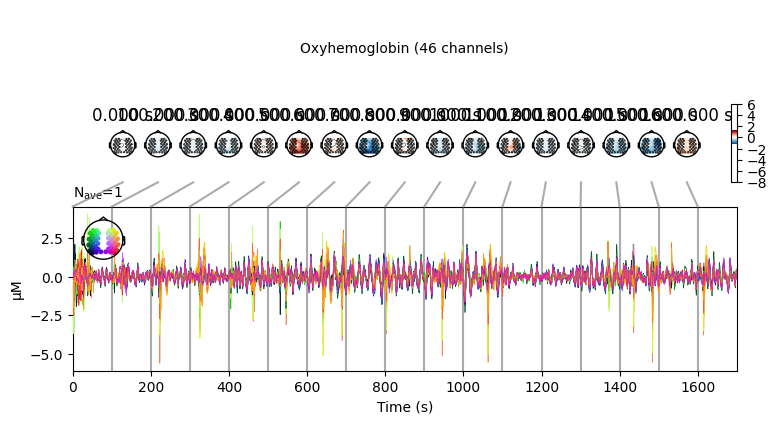

In [132]:
times = np.arange(0, 1700, 100)
topomap_args = dict(extrapolate='local')
epochs['1'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args)


array([ 10,  30,  50,  70,  90, 110])